http://www.petroanalytix.com/

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.signal as ff

from numpy.linalg import inv

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook

### Scoring Method

In [2]:
def accuracy(conf):
     total_correct = 0.
     nb_classes = conf.shape[0]
     for i in np.arange(0,nb_classes):
         total_correct += conf[i][i]
     acc = total_correct/sum(sum(conf))
     return acc

def adjacent_facies_evaluation():
    adjacent_facies = np.array([[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]])
    return adjacent_facies

def accuracy_adjacent(conf, adjacent_facies):
     nb_classes = conf.shape[0]
     total_correct = 0.
     for i in np.arange(0,nb_classes):
         total_correct += conf[i][i]
         for j in adjacent_facies[i]:
             total_correct += conf[i][j]
     return total_correct / sum(sum(conf))

### Load dataset

In [3]:
training_data = pd.read_csv('../data/facies_vectors.csv')
test_data = pd.read_csv('../data/nofacies_data.csv')

###### Feature Engineering 0 : Outlier Removal

In [4]:
def z_score(points, thresh=4.5):
    average = np.mean(points)
    std_deviation = np.std(points,ddof =1)
    zscore = (points-average)/std_deviation
    #print(zscore)
    
    return abs(zscore),abs(zscore) > thresh

In [5]:
# import od_methods_raw as odr
[Scores,indices] = z_score(training_data['GR'].values,3.5)
ind = np.where(indices==True)
# print(len(ind[0]))
training_data.drop(training_data.index[ind[0]],inplace=True)
[Scores,indices] = z_score(training_data['ILD_log10'].values,3.5)
ind = np.where(indices==True)
# print(len(ind[0]))
training_data.drop(training_data.index[ind[0]],inplace=True)
[Scores,indices] = z_score(training_data['PHIND'].values,3.5)
ind = np.where(indices==True)
# print(len(ind[0]))
training_data.drop(training_data.index[ind[0]],inplace=True)
[Scores,indices] = z_score(training_data['DeltaPHI'].values,3.5)
ind = np.where(indices==True)
# print(len(ind[0]))
training_data.drop(training_data.index[ind[0]],inplace=True)

###### FEATURE ENGINEERING 1 : Applying Second Order filter

In [6]:
def filtercurves(points):
    b, a = ff.butter(2, 0.5, 'low')
    output_signal = ff.filtfilt(b, a, points)
    return output_signal

def second_order_filter(df):
    for cnt in df['Well Name'].unique():
        idx = df['Well Name'] == cnt
        
        signal = df[idx]['GR'].values
        out_signal = filtercurves(signal)
        df.ix[idx,'GR'] = out_signal
        
        signal = df[idx]['ILD_log10'].values
        out_signal = filtercurves(signal)
        df.ix[idx,'ILD_log10'] = out_signal
        
        signal = df[idx]['PHIND'].values
        out_signal = filtercurves(signal)
        df.ix[idx,'PHIND'] = out_signal
        
    return df

In [7]:
training_data = second_order_filter(training_data)

###### FEATURE ENGINEERING 2 : PE Imputation using PCA

In [8]:
import warnings
warnings.filterwarnings('ignore')

complete_data = pd.read_csv('../data/training_data.csv')
PE = complete_data.ix[complete_data['PE'].isnull() == False,'PE']
PEscaler = preprocessing.StandardScaler().fit(PE)

for cnt in complete_data['NM_M'].unique():
    X_raw_pca = complete_data[complete_data['NM_M']==cnt].drop(['Formation', 'Well Name', 'Depth', 'Facies','NM_M'], axis=1).values
    scaler = preprocessing.StandardScaler().fit(X_raw_pca)
    X_scaled_pca = scaler.transform(X_raw_pca)
    pca = PCA()
    pca.fit(X_raw_pca)
    no_of_components = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)
    n=(no_of_components[0][0])
    pca = PCA(n_components=n)
    pca.fit(X_scaled_pca)
    Comp = pca.components_
    Reduced_Comp = np.delete(Comp,[4], axis=1)
    inversematrix = inv(np.dot(Reduced_Comp,Reduced_Comp.T))
    UsableVector = np.dot(np.dot(pca.components_.T,inversematrix),Reduced_Comp)
    
    # Reconstruction of null PE
    idx = training_data[ (training_data['PE'].isnull() == True) & (training_data['NM_M']==cnt)].index
    reconstruction_vector = training_data.loc[idx,['GR','ILD_log10','DeltaPHI','PHIND','RELPOS']].values
    scaler = preprocessing.StandardScaler().fit(reconstruction_vector)
    reconstruction_scaled_vector = scaler.transform(reconstruction_vector)
    
    CC = np.zeros(len(idx[:]))
    for cnt in range(0,len(idx[:])):
        A = np.zeros(5)
        A[0] = reconstruction_scaled_vector[cnt,0]
        A[1] = reconstruction_scaled_vector[cnt,1]
        A[2] = reconstruction_scaled_vector[cnt,2] 
        A[3] = reconstruction_scaled_vector[cnt,3]
        A[4] = reconstruction_scaled_vector[cnt,4]
        M = np.dot(UsableVector,A)
        CC[cnt] = M[4]
    
    training_data.ix[idx,'PE'] = PEscaler.inverse_transform(CC)

### Model Testing and Validation

In [9]:
# Model
def perform_ada_boost_random_forest_evaluation(Xtrain,Ytrain,Xtest,Ytest):
    adjacent_facies = adjacent_facies_evaluation()
    adaboost = AdaBoostClassifier(base_estimator = RandomForestClassifier(n_estimators=50, criterion='gini', n_jobs=4, max_depth=10, random_state=42),n_estimators = 10, random_state =42)
    adaboost.fit(Xtrain,Ytrain)
    output = adaboost.predict(Xtest)
    f1score = f1_score(Ytest, output, average="weighted")
    conf = confusion_matrix(Ytest,output)
    try:
        conf = confusion_matrix(Ytest-1, output-1, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])  # -1, because adjacent facies use 0 - 8
        acc = accuracy(conf)
    except:
        acc = 0
    
    try:
        acc_adj = accuracy_adjacent(conf, adjacent_facies)
    except:
        acc_adj = 0
        
    return f1score,acc,acc_adj

for nm_m in training_data['NM_M'].unique():
    X = training_data[training_data['NM_M'] == nm_m].drop(['Formation', 'Well Name', 'Depth', 'Facies'], axis=1).values
    y = training_data[training_data['NM_M'] == nm_m]["Facies"].values
    wells = training_data[training_data['NM_M'] == nm_m]["Well Name"].values
    print()
    logo = LeaveOneGroupOut()
    for train, test in logo.split(X, y, groups=wells):
        well_name = wells[test[0]]
        nd = len(y[test])
        [f1,acc,adj_acc] = perform_ada_boost_random_forest_evaluation(X[train], y[train], X[test], y[test])
        print("{:>20s} f1:{:.3f} | acc:{:.3f} | acc_adj:{:.3f} | samples:{:g}".format(well_name, f1, acc, adj_acc, nd))


         ALEXANDER D f1:0.724 | acc:0.731 | acc_adj:1.000 | samples:208
     CHURCHMAN BIBLE f1:0.519 | acc:0.552 | acc_adj:0.931 | samples:87
      CROSS H CATTLE f1:0.237 | acc:0.258 | acc_adj:0.870 | samples:330
            KIMZEY A f1:0.568 | acc:0.586 | acc_adj:0.970 | samples:169
            LUKE G U f1:0.651 | acc:0.638 | acc_adj:0.996 | samples:243
               NEWBY f1:0.627 | acc:0.601 | acc_adj:0.983 | samples:178
               NOLAN f1:0.677 | acc:0.709 | acc_adj:0.949 | samples:196
             SHANKLE f1:0.396 | acc:0.465 | acc_adj:0.956 | samples:275
           SHRIMPLIN f1:0.618 | acc:0.635 | acc_adj:1.000 | samples:241

         ALEXANDER D f1:0.465 | acc:0.488 | acc_adj:0.853 | samples:258
     CHURCHMAN BIBLE f1:0.488 | acc:0.534 | acc_adj:0.819 | samples:277
      CROSS H CATTLE f1:0.306 | acc:0.343 | acc_adj:0.762 | samples:143
            KIMZEY A f1:0.341 | acc:0.378 | acc_adj:0.805 | samples:262
            LUKE G U f1:0.614 | acc:0.600 | acc_adj:0.914 | sam

### Applying to Test Wells

In [10]:
test_data = second_order_filter(test_data)

In [11]:
# Initialize column
test_data["Facies"] = np.arange(len(test_data))

for nm_m in training_data['NM_M'].unique():
# nm_m = 1
    X = training_data[training_data['NM_M'] == nm_m].drop(['Formation', 'Well Name', 'Depth', 'Facies'], axis=1).values
    y = training_data[training_data['NM_M'] == nm_m]["Facies"].values

    Xtest = test_data[test_data['NM_M'] == nm_m].drop(['Formation', 'Well Name', 'Depth', 'Facies'], axis=1).values

    adaboost = AdaBoostClassifier(base_estimator = RandomForestClassifier(n_estimators=50, criterion='gini', n_jobs=4, max_depth=10, random_state=42),n_estimators = 10, random_state =42)
    adaboost.fit(X,y)

    test_data["Facies"][test_data['NM_M'] == nm_m] = adaboost.predict(Xtest)

In [12]:
test_data.to_csv("PA_Team_Submission_1.csv")

In [13]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [14]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

<IPython.core.display.Javascript object>


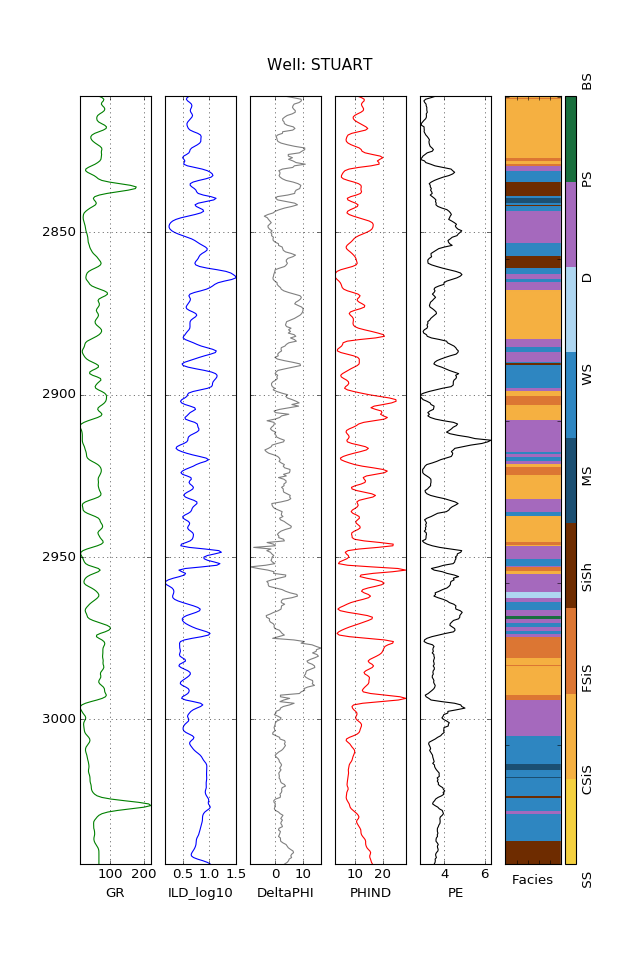

In [15]:
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors)

<IPython.core.display.Javascript object>


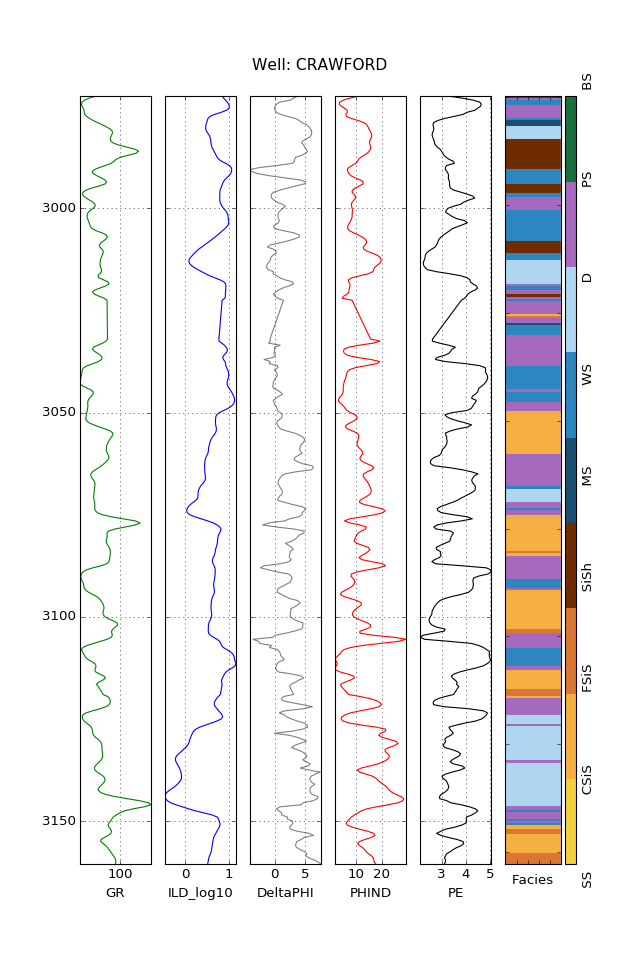

In [16]:
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors)